# Uncapacitated Multiple Allocation HLP Problem.

**Pablo García Pérez**

El problema Uncapacitated Multiple Allocation Hub Location Problem es una variante del problema de localización de hubs (Hub Location Problem). Este problema se enfoca en determinar la ubicación óptima de hubs y cómo enrutar el tráfico de demanda entre un conjunto de nodos en una red, minimizando costos de transporte y de establecimiento de hubs. A continuación, se explican sus elementos principales:

___
 ## Descripción del problema
 - Hubs: Son nodos especiales que actúan como puntos intermedios de consolidación y distribución de flujos en la red.
 - Demanda: Existe una matriz de demanda entre nodos que especifica el tráfico que debe moverse de un nodo a otro.
- Costos:
1 Establecimiento de hubs: Costos asociados con abrir un hub en un nodo.
2 Transporte: Costos asociados con mover la demanda entre nodos a través de hubs.

___
 ## Variables del modelo
 ### **Variables del modelo en formato Markdown**

1. **Variables binarias de decisión**  
   - \( x_k \): Indica si se abre un hub en el nodo \( k \).  
     - \( x_k = 1 \): Hub abierto en el nodo \( k \).  
     - \( x_k = 0 \): Hub no abierto en el nodo \( k \).

2. **Variables de flujo**  
   - \( f_{ijhk} \): Fracción de la demanda entre los nodos \( i \) y \( j \) que pasa a través de los hubs \( h \) y \( k \).  
     - \( i, j \): Nodos de origen y destino.  
     - \( h, k \): Hubs utilizados para enrutar el flujo entre \( i \) y \( j \).  

---
 ## Restricciones del modelo
 1. Asignación múltiple de rutas: Cada par de nodos i y j debe satisfacer su demanda usando una combinación de hubs

 2. Flujo condicionado a hubs abiertos, el flujo a través de un hub h o k solo es posible si esos hubs están abiertos

3. Restricción de cantidad de hubs abiertos, existe un límite superior en la cantidad total de hubs están abiertos

4. No hay restricciones de capacidad, en esta versión del problema, los hubs no tienen límites en la cantidad de flujo que pueden manejar


In [7]:
import Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Plots")


using JuMP, GLPK, Random, Plots, Random, LinearAlgebra

   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`


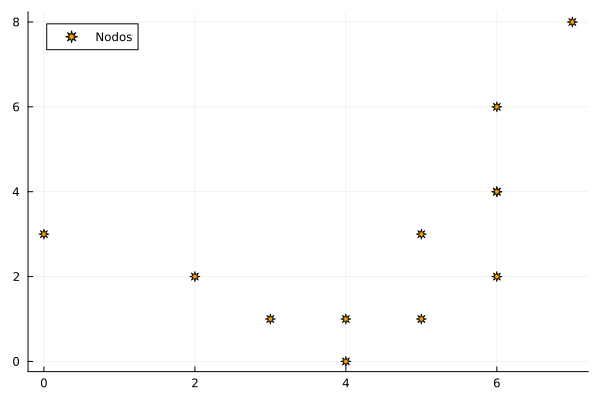

In [4]:
# Importar librerías necesarias
using Random
using Plots

# Fijar semilla para reproducibilidad
Random.seed!(1234)  # Cambiar el valor de la semilla

# Parámetros iniciales
num_nodos = 12                 # Número total de nodos
num_hubs_a_abrir = 5           # Número de hubs que se van a abrir
conjunto_nodos = 1:num_nodos   # Conjunto de nodos indexados del 1 al n

demanda = rand(1:10, num_nodos, num_nodos)    # Matriz aleatoria de demanda entre nodos
costo_hub = rand(1:10, num_nodos)             # Vector aleatorio de costos de establecer hubs
costo_transporte = rand(1:10, num_nodos, num_nodos)  # Matriz de costos de transporte

# Ajustar costos de transporte y demanda en la diagonal principal
for origen in conjunto_nodos
    costo_transporte[origen, origen] = 0  # Costo de transporte desde un nodo a sí mismo es cero
    demanda[origen, origen] = 0           # La demanda interna entre un nodo a sí mismo también es cero
end

# Garantizar que los costos de transporte cumplan con la desigualdad triangular
for origen in conjunto_nodos
    for destino in conjunto_nodos
        for intermediario in conjunto_nodos
            costo_transporte[origen, destino] = min(
                costo_transporte[origen, destino],
                costo_transporte[origen, intermediario] + costo_transporte[intermediario, destino]
            )
        end
    end
end

# Crear un diccionario con coordenadas ficticias para los nodos
coordenadas_nodos = Dict()
for nodo in conjunto_nodos
    coordenadas_nodos[nodo] = (costo_transporte[nodo, 1], costo_transporte[nodo, 2])
end

# Factores de costo para diferentes etapas del transporte
factor_descuento = 0.8     # Factor de descuento para costos en rutas de hubs
factor_recoleccion = 1.2   # Factor de recolección
factor_distribucion = 1.5  # Factor de distribución

# Calcular los costos de transporte ajustados considerando las etapas: recolección, traslado y distribución
costo_ajustado = zeros(num_nodos, num_nodos, num_nodos, num_nodos)
for origen in conjunto_nodos, destino in conjunto_nodos, hub1 in conjunto_nodos, hub2 in conjunto_nodos
    costo_ajustado[origen, destino, hub1, hub2] = 
        factor_recoleccion * costo_transporte[origen, hub1] +
        factor_descuento * costo_transporte[hub1, hub2] +
        factor_distribucion * costo_transporte[hub2, destino]
end

# Funciones de visualización

# Dibujar la instancia de nodos en un espacio 2D
function GraficarNodos(nodos, coords, escala = 1.0)
    # Extraer coordenadas X e Y de los nodos
    coord_x = [coords[n][1] for n in nodos]
    coord_y = [coords[n][2] for n in nodos]

    # Crear el gráfico con los nodos representados como puntos verdes
    plot_instancia = scatter(
        coord_x, 
        coord_y;
        label = "Nodos",
        markershape = :star8,
        markercolor = :orange,
        markersize = escala * 5
    )

    display(plot_instancia)
end

# Dibujar la solución del problema, mostrando hubs y conexiones
function GraficarSolucion(variable_hubs, variable_conexiones, nodos, coords, escala = 1.0)
    # Extraer coordenadas de los nodos
    coord_x = [coords[n][1] for n in nodos]
    coord_y = [coords[n][2] for n in nodos]

    # Inicializar el gráfico
    grafico = plot()

    # Dibujar los nodos
    scatter!(grafico, coord_x, coord_y; label="Nodos", markershape=:circle, markercolor=:green, markersize=escala * 5)

    # Dibujar conexiones entre nodos y hubs según las variables de decisión
    for nodo in nodos
        for hub in nodos
            if nodo != hub && any(value(variable_conexiones[nodo, destino, hub, hub2]) > 0.5 for destino in nodos, hub2 in nodos)
                plot!(
                    grafico, 
                    [coords[nodo][1], coords[hub][1]], 
                    [coords[nodo][2], coords[hub][2]];
                    color=:blue, label="", linewidth=2
                )
            end
        end
    end

    # Identificar hubs abiertos y representarlos con una estrella amarilla
    hubs_abiertos = []
    for hub in nodos
        if value(variable_hubs[hub]) > 0.5
            push!(hubs_abiertos, hub)
            scatter!(grafico, [coords[hub][1]], [coords[hub][2]]; 
                label="Hub $hub", markershape=:star5, markercolor=:yellow, markersize=escala * 10, markerstrokewidth=2)
        end
    end

    # Dibujar conexiones entre hubs abiertos
    for hub1 in hubs_abiertos
        for hub2 in hubs_abiertos
            if hub1 != hub2 && any(value(variable_conexiones[hub1, hub2, inter1, inter2]) > 0.5 for inter1 in nodos, inter2 in nodos)
                plot!(grafico, [coords[hub1][1], coords[hub2][1]], [coords[hub1][2], coords[hub2][2]];
                    color=:red, label="", linewidth=2)
            end
        end
    end

    # Ajustar límites del gráfico
    x_min, x_max = extrema(coord_x)
    y_min, y_max = extrema(coord_y)
    xlims!(grafico, x_min - 1, x_max + 1)
    ylims!(grafico, y_min - 1, y_max + 1)

    display(grafico)
end

# Dibujar la instancia inicial de nodos
GraficarNodos(conjunto_nodos, coordenadas_nodos)


Solución encontrada:
   Valor de la función objetivo: 3386.9999999999995
Hubs abiertos en las siguientes ubicaciones:
 - Hub en la ubicación 5
 - Hub en la ubicación 6
 - Hub en la ubicación 7
 - Hub en la ubicación 10
 - Hub en la ubicación 12

Rutas de demanda optimizadas:
Ruta de 1 a 2:
   Pasa a través del hub 12
Ruta de 1 a 3:
   Pasa a través de los hubs 12 y 7
Ruta de 1 a 4:
   Pasa a través de los hubs 12 y 7
Ruta de 1 a 5:
   Pasa a través de los hubs 12 y 5
Ruta de 1 a 6:
   Pasa a través de los hubs 12 y 6
Ruta de 1 a 7:
   Pasa a través de los hubs 12 y 7
Ruta de 1 a 8:
   Pasa a través del hub 12
Ruta de 1 a 9:
   Pasa a través de los hubs 12 y 6
Ruta de 1 a 10:
   Pasa a través del hub 10
Ruta de 1 a 11:
   Pasa a través del hub 10
Ruta de 1 a 12:
   Pasa a través del hub 12
Ruta de 2 a 1:
   Pasa a través de los hubs 12 y 6
Ruta de 2 a 3:
   Pasa a través de los hubs 12 y 7
Ruta de 2 a 4:
   Pasa a través de los hubs 12 y 7
Ruta de 2 a 5:
   Pasa a través del hub 5
Ruta 

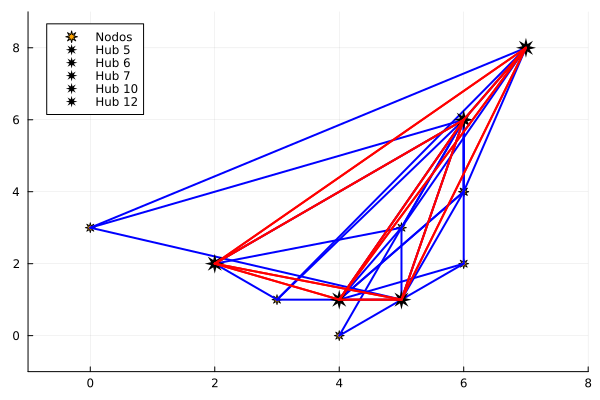

In [ ]:
function solveHLP()
    EPSILON = 1e-5  # Pequeño valor para manejo numérico
    modelo_HLP = Model(GLPK.Optimizer)  # Modelo de optimización usando GLPK

    # Variables de decisión
    @variable(modelo_HLP, hub_abierto[k in conjunto_nodos], Bin)  # Variables binarias para hubs
    @variable(modelo_HLP, flujo_ruta[i in conjunto_nodos, j in conjunto_nodos, hub1 in conjunto_nodos, hub2 in conjunto_nodos] >= 0)

    # Función objetivo: minimizar el costo total (demanda y costos de hubs)
    @objective(modelo_HLP, Min, 
        sum(demanda[i, j] * costo_ajustado[i, j, hub1, hub2] * flujo_ruta[i, j, hub1, hub2] for i in conjunto_nodos, j in conjunto_nodos, hub1 in conjunto_nodos, hub2 in conjunto_nodos) +
        sum(costo_hub[hub] * hub_abierto[hub] for hub in conjunto_nodos)
    )

    # Restricciones:
    # Cada par de nodos debe tener una ruta 
    @constraint(modelo_HLP, [origen in conjunto_nodos, destino in conjunto_nodos], 
        sum(flujo_ruta[origen, destino, hub1, hub2] for hub1 in conjunto_nodos, hub2 in conjunto_nodos) == 1
    )

    # El flujo entre nodos está condicionado a hubs abiertos
    @constraint(modelo_HLP, [origen in conjunto_nodos, destino in conjunto_nodos, hub1 in conjunto_nodos, hub2 in conjunto_nodos], 
        flujo_ruta[origen, destino, hub1, hub2] <= hub_abierto[hub1]
    )

    @constraint(modelo_HLP, [origen in conjunto_nodos, destino in conjunto_nodos, hub1 in conjunto_nodos, hub2 in conjunto_nodos], 
        flujo_ruta[origen, destino, hub1, hub2] <= hub_abierto[hub2]
    )

    # Restricción de cantidad de hubs abiertos
    @constraint(modelo_HLP, sum(hub_abierto[hub] for hub in conjunto_nodos) <= num_hubs_a_abrir)

    # Resolver el modelo
    optimize!(modelo_HLP)

    # Mostrar la solución
    if termination_status(modelo_HLP) == OPTIMAL
        println("Solución encontrada:")
        println("   Valor de la función objetivo: ", objective_value(modelo_HLP))

        # Mostrar hubs abiertos
        println("Hubs abiertos en las siguientes ubicaciones:")
        for hub in conjunto_nodos
            if value(hub_abierto[hub]) > 0.5  # Hubs abiertos
                println(" - Hub en la ubicación $hub")
            end
        end

        # Mostrar rutas de demanda
        println("\nRutas de demanda optimizadas:")
        for origen in conjunto_nodos, destino in conjunto_nodos
            if origen != destino
                println("Ruta de $origen a $destino:")
                for hub1 in conjunto_nodos, hub2 in conjunto_nodos
                    if value(flujo_ruta[origen, destino, hub1, hub2]) > EPSILON
                        if hub1 == hub2
                            println("   Pasa a través del hub $hub1")
                        else
                            println("   Pasa a través de los hubs $hub1 y $hub2")
                        end
                    end
                end
            end
        end

        # Visualizar la solución en un gráfico
        GraficarSolucion(value.(hub_abierto), value.(flujo_ruta), conjunto_nodos, coordenadas_nodos)
    else
        println("El modelo no tiene una solución factible.")
        return -1
    end 
end

# Ajuste de la función GraficarSolucion para que coincida con el formato del primer código
function GraficarSolucion(variable_hubs, variable_conexiones, nodos, coords, escala = 1.0)
    # Extraer coordenadas de los nodos
    coord_x = [coords[n][1] for n in nodos]
    coord_y = [coords[n][2] for n in nodos]

    # Inicializar el gráfico
    grafico = plot()

    # Dibujar los nodos
    scatter!(grafico, coord_x, coord_y; 
        label="Nodos", 
        markershape=:star8, 
        markercolor=:orange, 
        markersize=escala * 5)

    # Dibujar conexiones entre nodos y hubs según las variables de decisión
    for nodo in nodos
        for hub in nodos
            if nodo != hub && any(value(variable_conexiones[nodo, destino, hub, hub2]) > 0.5 for destino in nodos, hub2 in nodos)
                plot!(
                    grafico, 
                    [coords[nodo][1], coords[hub][1]], 
                    [coords[nodo][2], coords[hub][2]];
                    color=:blue, label="", linewidth=2
                )
            end
        end
    end

    # Identificar hubs abiertos y representarlos con una estrella amarilla
    hubs_abiertos = []
    for hub in nodos
        if value(variable_hubs[hub]) > 0.5
            push!(hubs_abiertos, hub)
            scatter!(grafico, [coords[hub][1]], [coords[hub][2]]; 
                label="Hub $hub", markershape=:star8, markercolor=:black, markersize=escala * 10, markerstrokewidth=2)
        end
    end

    # Dibujar conexiones entre hubs abiertos
    for hub1 in hubs_abiertos
        for hub2 in hubs_abiertos
            if hub1 != hub2 && any(value(variable_conexiones[hub1, hub2, inter1, inter2]) > 0.5 for inter1 in nodos, inter2 in nodos)
                plot!(grafico, [coords[hub1][1], coords[hub2][1]], [coords[hub1][2], coords[hub2][2]];
                    color=:orange, label="", linewidth=2)
            end
        end
    end

    # Ajustar límites del gráfico
    x_min, x_max = extrema(coord_x)
    y_min, y_max = extrema(coord_y)
    xlims!(grafico, x_min - 1, x_max + 1)
    ylims!(grafico, y_min - 1, y_max + 1)

    display(grafico)
end

solveHLP()